In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from uncertainty_matrix_to_discrete import UncertaintyMatrix, convert_flowmat_to_infmat
from differential_propagation_model import diff_propagation
import seaborn as sns

SEED = 1657
rng = np.random.default_rng(seed=SEED)

actual_arrival_times = rng.integers(15, 150, size=(133, 133))

flow_matrix_path = "../recovery_rate/recovery_rate_training_dataframes/data/all_time_flight_flow_df_rev1.pickle"
flight_flow_data = pd.read_pickle(flow_matrix_path)

apt_df_path = "../recovery_rate/recovery_rate_training_dataframes/data/airport_state_weather_prediction_added_rev1.pickle"
apt_df = pd.read_pickle(apt_df_path)

inf_matrix_path = "../recovery_rate/recovery_rate_training_dataframes/data/all_time_infection_rate_df_rev1.pickle"
inf_matrix_df =  pd.read_pickle(inf_matrix_path)

#Data preprocess.
#Clip the normalized delay to [0, 1].
apt_df["norm_delay_per_f"] = apt_df["norm_delay_per_f"].clip(lower=0, upper=1.0).values
median_rr_values = apt_df["recovery_rate"].median()
apt_df["recovery_rate"] = apt_df["recovery_rate"].fillna(method="backfill").fillna(median_rr_values).values



In [75]:
random_idx = rng.integers(0, len(flight_flow_data)/133)
random_slice = slice(random_idx*133, (random_idx+1)*133)
random_flow_matrix_pattern = flight_flow_data.iloc[random_slice, :]

uncertainty_mat = UncertaintyMatrix(random_flow_matrix_pattern.values, mean_values=actual_arrival_times)
actual_without_uncertainty = UncertaintyMatrix(random_flow_matrix_pattern.values, mean_values=actual_arrival_times, std_values=np.zeros(shape=(133, 133)))

arrays = uncertainty_mat.draw_sample(100)
flow_matrix_nested_list = [to_flowmatrix(array) for array in arrays]
convert_flowmat_to_infmat(flow_matrix_nested_list)

actual_array = actual_without_uncertainty.draw_sample(1)[0]
actual_flow_matrix = [to_flowmatrix(actual_array)]
convert_flowmat_to_infmat(actual_flow_matrix)


In [76]:
sliced_apt_df = apt_df.iloc[random_slice, :]

p_zero = sliced_apt_df["norm_delay_per_f"].values
p_next = apt_df.iloc[(random_idx+1)*133, :].loc["norm_delay_per_f"]
p_list = [p_zero]
for inf_matrix in [inf_matrix_df.iloc[random_slice, :].values]:
    p_dot_vector = diff_propagation(p_list[-1], sliced_apt_df["recovery_rate"].values, inf_matrix)
    
    p_list.append(np.clip(np.add(p_list[-1], p_dot_vector), 0, 1))
                
    

In [61]:
len(flow_matrix_nested_list)

100

In [77]:
samples = []
for sublist in flow_matrix_nested_list:
    p_list = [p_zero]
    inf_matrix = sublist[0]
    p_dot_vector = diff_propagation(p_list[-1], sliced_apt_df["recovery_rate"].values, inf_matrix)
    p_list.append(np.clip(np.add(p_list[-1], p_dot_vector), 0, 1))
    samples.append(p_list)

In [68]:
len(samples[2][0])

133

In [ ]:
idx = 13
sns.lineplot(x=range(len(p_list)), y=[sublist[idx] for sublist in p_list])
sns.lineplot(x=range(len(p_list)), y=[p_zero[idx], p_next])
for i in samples:
    next_ = i[1][idx]
    sns.lineplot(x=range(len(p_list)), y=[p_zero[idx], next_])


In [11]:
#Test_case
test_date = "2018-04-15"
test_tw_range = slice(0, 92)
test_apt = "EDDM"

mult_index = (test_date, test_tw_range, [test_apt])
mult_index_all_apt = (test_date, test_tw_range, slice(None))

test_df = apt_df.loc[mult_index, ["recovery_rate", "norm_delay_per_f"]]
test_apt_index = apt_df.index.unique("apt").tolist().index(test_apt)

test_df["inf_matrix"] = [inf_matrix_df.loc[mult_index_all_apt, :].iloc[i:i+133, :].values for i in range(0, len(inf_matrix_df.loc[mult_index_all_apt, :]), 133)]
test_df["p_state_vectors"] = [apt_df.loc[mult_index_all_apt, "norm_delay_per_f"].iloc[i:i+133].values for i in range(0, len(apt_df.loc[mult_index_all_apt, :]), 133)]
test_df["recovery_rate_vectors"] = [apt_df.loc[mult_index_all_apt, "recovery_rate"].iloc[i:i+133].values for i in range(0, len(apt_df.loc[mult_index_all_apt, :]), 133)]

result = diff_propagation(test_df["p_state_vectors"].values, test_df["recovery_rate_vectors"].values, test_df["inf_matrix"].values)

test_df["calculated_p_states"] = [p_state_vector[test_apt_index] for p_state_vector in result[:-1]]


In [13]:
test_apt_index

6

<AxesSubplot:xlabel='date,tw,apt'>

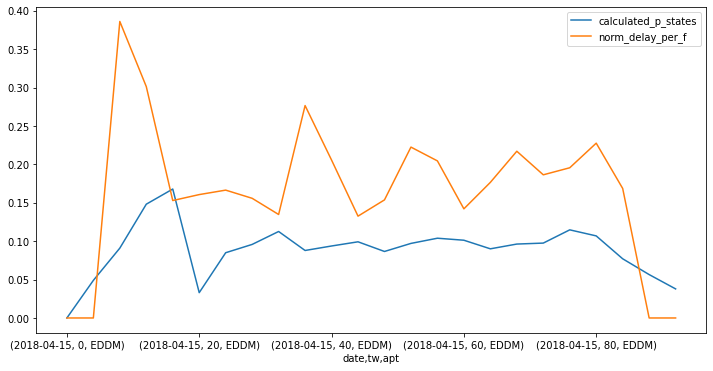

In [12]:
test_df.loc[:, ["calculated_p_states", "norm_delay_per_f"]].plot(figsize=(12, 6))